<a href="https://www.assemblyai.com/">
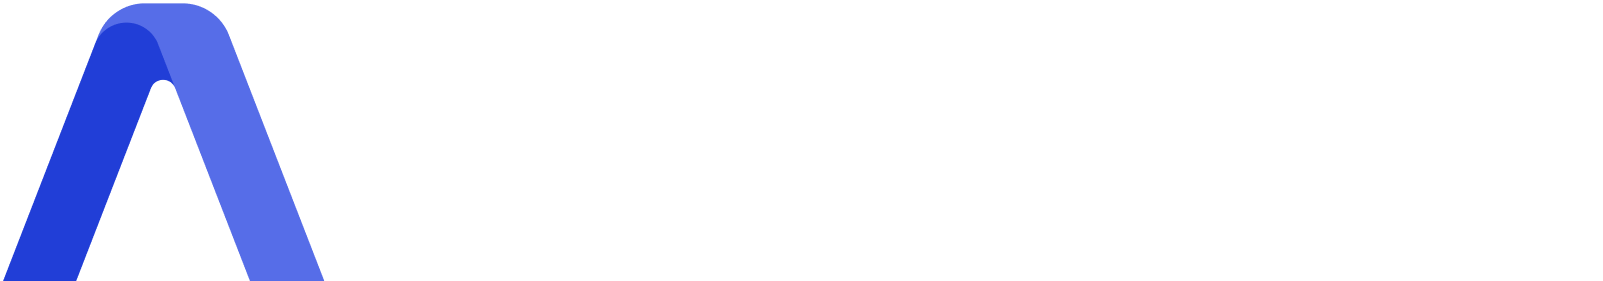
</a>
</img>

## Overview

Extracting exact quotes from transcripts can be a difficult task for Large Language Models which makes it challenging to cite sources or identify timestamps for generative text.

Embeddings are powerful representations of text that capture its semantic and contextual meaning. By leveraging embeddings, we can transform raw text data, such as transcripts, into dense numerical vectors that encode its underlying information. These embeddings enable us to perform sophisticated tasks such as similarity comparison and contextual searching.


In this Colab, we'll show you how to use AssemblyAI's LeMUR (Leveraging Large Language Models to Understand Recognized Speech) framework to process an audio file and then use [LeMUR's Question & Answer feature](https://www.assemblyai.com/docs/API%20reference/lemur) and OpenAI embeddings to automatically extract exact quotes from the transcript.

## Quickstart

Before we begin, make sure you have an AssemblyAI account and an API key. You can [sign up for an AssemblyAI account](https://www.assemblyai.com/app) and get your API key from your dashboard.

You'll need to install a few extra packages that help take advantage of the [OpenAI embeddings](https://platform.openai.com/docs/guides/embeddings) this tutorial relies on.

You'll also need an API key from OpenAI. [Get an OpenAI API key from the OpenAI User Settings.](https://platform.openai.com/account/api-keys)

### Initial Setup & Installation

First, install and import all the libraries you'll need and set both your OpenAI and AssemblyAI API keys.

In [ ]:
# pip install openai tiktoken numpy scikit-learn assemblyai
import json
import openai
import tiktoken
import numpy as np
import assemblyai as aai
from sklearn.neighbors import NearestNeighbors

aai.settings.api_key = "your_assemblyai_api_key"
openai.api_key = "your_openai_api_key"

### Defining Helper Functions

Next, define the following helper functions to create your transcript embeddings. We'll be using the [text-embedding-ada-002 model from OpenAI](https://platform.openai.com/docs/guides/embeddings/embedding-models) to generate our embeddings. The pricing for this model is $0.0001/tk tokens at the time of writing this, which equates to roughly $0.0015 to embed one hour of audio.

In [ ]:
def embed_block(block_text):
    # Embed the text block using OpenAI embeddings.
    embedding = openai.Embedding.create(
        input=block_text,
        model='text-embedding-ada-002',
    ).to_dict()['data'][0]['embedding']

    # Store the embedding with the timestamp in the dictionary.
    return embedding


def find_relevant_matches(embedded_blocks, new_block_text, k=3):
    matches = []

    # Embed the new block of text using OpenAI embeddings.
    new_embedding = embed_block(new_block_text)

    # Prepare the embeddings for the KNN search.
    embeddings = np.array(list(embedded_blocks.values()))
    metadata = list(embedded_blocks.keys())

    # Perform KNN search to find the most relevant matches.
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(embeddings)
    distances, indices = knn.kneighbors([new_embedding])

    # Print the relevant matches.
    for distance, index in zip(distances[0], indices[0]):
        result_metadata = metadata[index]
        matches.append({
            'timestamp': result_metadata[0],
            'transcript_id': result_metadata[1],
            'text': result_metadata[2],
            'confidence': 1-distance
        })
    return matches


def create_transcript_embeddings(transcript, granularity='paragraph'):
    # Dictionary to store embeddings with timestamps.
    embeddings = {}
    total_tokens_embedded = 0

    if granularity == 'sentence':
        sentences = transcript.get_sentences()
        for sentence in sentences:
            total_tokens_embedded += num_tokens_from_string(
                sentence.text, 'r50k_base')
            embeddings[(sentence.start, transcript.id, sentence.text)
                       ] = embed_block(sentence.text)
    else:
        paragraphs = transcript.get_paragraphs()
        for paragraph in paragraphs:
            total_tokens_embedded += num_tokens_from_string(
                paragraph.text, 'r50k_base')
            embeddings[(paragraph.start, transcript.id, paragraph.text)
                       ] = embed_block(paragraph.text)
    return embeddings


def num_tokens_from_string(string, encoding_name):
    # Returns the number of tokens in a text string.
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

### Prompting LeMUR

Next, write your question(s) to LeMUR in whichever format you like. For this example, we'll ask a question to extract meeting insights with another small helper function to help generate our expected `answer_format`.

In [ ]:
questions = [
    aai.LemurQuestion(question="What are the action items from this meeting?",
                      context='',
                      answer_format="""
        [{
            "action_item":<action_item>,
            "assignee":<assignee>,
            "quote":<leave blank>",
            "timestamp":"<leave blank>"
        }]
        """
                      ),
]


def timestamp_action_items(action_items_array, embeddings):
    for action_item in action_items_array:
        matches = find_relevant_matches(
            embeddings, action_item['action_item'], k=1)
        for m in matches:
            action_item['quote'] = m['text']
            action_item['timestamp'] = m['timestamp']
        return action_items_array

### Putting it All Together

Finally, create a transcript and pass all that informatino through the functions we just wrote.

In [ ]:
transcriber = aai.Transcriber()
transcript = transcriber.transcribe('your_audio_url_here')

embeddings = create_transcript_embeddings(transcript)

qa_results = transcript.lemur.question(questions)

print(f"Question: {qa_results.question}")
print()

action_item_json_array = json.loads(qa_results.answer.strip())
action_item_json_array = timestamp_action_items(action_item_json_array, embeddings)

print(json.dumps(action_item_json_array, indent=4))

The output will look similar to the example below.

In [ ]:
[
  {
    "action_item": "Schedule a meeting with Rohan and Connor to discuss the upcoming sprints.",
    "assignee": "Jason",
    "quote": "I think we should figure out how this fits into our sprints over the next few weeks. Rohan, do you want to get on a meeting soon and maybe invite Connor from Product?",
    "timestamp": 223210
  }
]